## Enunciado da Questão

Utilize uma rede neural perceptron de múltiplas camadas para aproximar a função analítica  abaixo.  


$$f(x_1, x_2) = (x_1^2 + x_2^2)\frac{\sin\big(\pi(x_1 + x_2)\big)}{\pi(x_1 + x_2)} + x_1x_2 - 0.5$$


$$\begin{cases}
-10 \leq x_1 \leq 10 \\
-10 \leq x_2 \leq 10
\end{cases}
$$

Com base na função gere o conjunto de treinamento e de teste. Defina a arquitetura da rede e a realize o treinamento.  Apresente um gráfico com a curva da função analítica e a curva da função aproximada pela rede neural. Apresente também  a curva da função custo no treinamento e a curva do erro médio quadrado com relação ao o conjunto de validação. Procure definir a arquitetura da  rede neural perceptron, isto é, o número de entradas, o número de neurônios em cada camada e o número de neurônios camada de saída.  Observação. Como se trata de um problema de aproximação de funções, considere a camada de saída do tipo linear puro.

### 1. Gerando Dados

In [1]:
import numpy as np
import torch
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

N_POINTS = 50 # Número de pontos em cada eixo
TEST_SIZE = 0.2

def f(x1, x2):
    s = x1 + x2
    # Usar np.where para tratar o caso s = 0 de forma vetorizada
    sinc_term = np.where(s == 0, 1.0, np.sin(np.pi * s) / (np.pi * s))
    
    return (x1**2 + x2**2) * sinc_term + x1 * x2 - 0.5
# Grid
x = np.linspace(-10, 10, N_POINTS)
y = np.linspace(-10, 10, N_POINTS)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

X_tensor = torch.tensor(np.column_stack((X.ravel(), Y.ravel())), dtype=torch.float32)
y_tensor = torch.tensor(Z.ravel(), dtype=torch.float32).unsqueeze(1)

### 2. Separando Dados de Treinamento e Teste

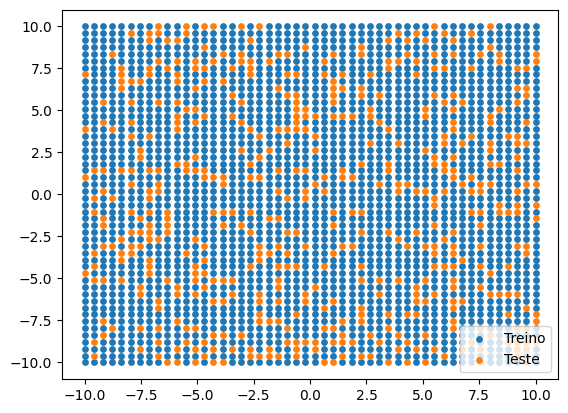

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=TEST_SIZE)

plt.scatter(X_train[:, 0], X_train[:, 1], s=15, label='Treino')
plt.scatter(X_test[:, 0], X_test[:, 1], s=15, label='Teste')

plt.legend(loc='lower right')
plt.show()

### 3. Regressor

In [3]:
from torch import nn
from torch.utils.data import Dataset, DataLoader

class FunctionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = FunctionDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class Regressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.layer3 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.layer4 = nn.Linear(in_features=hidden_size, out_features=output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.sigmoid(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        x = self.layer4(x)
        return x
    

In [6]:
import matplotlib.pyplot as plt
import os

NUM_EPOCHS = 100
LR = 0.01

regressor = Regressor(input_size=2, hidden_size=64, output_size=1)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(regressor.parameters(), lr=LR)

os.makedirs("frames", exist_ok=True)

# Loop de treinamento
for epoch in range(NUM_EPOCHS):
    # --- Treino ---
    regressor.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = regressor(X_train)
        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    # --- Avaliação ---
    if epoch % 2 == 0:      
        avg_loss = running_loss / len(train_dataset)
        print(f'Época {epoch} - Loss Médio: {avg_loss:.6f}')

        regressor.eval()
        with torch.no_grad():
            y_pred = regressor(X_tensor).numpy().reshape(X.shape)
            #print(y_pred)
        
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Função Real
        #ax.plot_surface(X, Y, Z, cmap='Reds')
        ax.plot_wireframe(X, Y, Z, alpha=0.2, color='red', label='Função Real')

        # Aproximação da Rede
        ax.plot_wireframe(X, Y, y_pred, alpha=0.5, color='black', label='Função Aproximada')

        ax.set_title(f'Época {epoch}/{NUM_EPOCHS} - Loss: {avg_loss:.5f} - Learning Rate: {LR}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.view_init(elev=30, azim=epoch)

        plt.tight_layout()
        plt.legend()
        plt.savefig(f'frames/frames_{epoch:04d}.png', dpi=150)
        plt.close()

Época 0 - Loss Médio: 1166.968147
Época 2 - Loss Médio: 530.752717
Época 4 - Loss Médio: 327.397031
Época 6 - Loss Médio: 297.726205
Época 8 - Loss Médio: 287.587110
Época 10 - Loss Médio: 280.338052
Época 12 - Loss Médio: 251.170549
Época 14 - Loss Médio: 170.341693
Época 16 - Loss Médio: 103.691472
Época 18 - Loss Médio: 65.232973
Época 20 - Loss Médio: 47.323348
Época 22 - Loss Médio: 37.669792
Época 24 - Loss Médio: 28.533888
Época 26 - Loss Médio: 24.545453
Época 28 - Loss Médio: 22.820556
Época 30 - Loss Médio: 19.374294
Época 32 - Loss Médio: 18.621886
Época 34 - Loss Médio: 16.438269
Época 36 - Loss Médio: 19.745246
Época 38 - Loss Médio: 14.522674
Época 40 - Loss Médio: 13.743513
Época 42 - Loss Médio: 17.992919
Época 44 - Loss Médio: 12.613114
Época 46 - Loss Médio: 12.109210
Época 48 - Loss Médio: 11.835858
Época 50 - Loss Médio: 11.547700
Época 52 - Loss Médio: 11.015126
Época 54 - Loss Médio: 10.701401
Época 56 - Loss Médio: 13.289281
Época 58 - Loss Médio: 10.260335
Época

In [5]:
import glob
from PIL import Image

def create_gif_with_pillow(image_folder, output_gif_path, duration=200, loop=0):
    """
    Creates an animated GIF from images in a specified folder using Pillow.

    Args:
        image_folder (str): Path to the folder containing the images.
        output_gif_path (str): Path where the GIF will be saved.
        duration (int): Duration of each frame in the GIF in milliseconds (default is 200 ms).
        loop (int): Number of times the GIF should loop (0 for infinite loop).
    """
    image_files = sorted(glob.glob(f"{image_folder}/*.png")) # Adjust extension as needed
    if not image_files:
        print(f"No images found in the specified folder: {image_folder}")
        return

    images = [Image.open(f) for f in image_files]

    if not images:
        print("No images to process.")
        return

    # Get the first image to use as the base for saving
    first_image = images[0]

    # Save the GIF
    first_image.save(
        fp=output_gif_path,
        format='GIF',
        append_images=images[1:], # Append all images after the first
        save_all=True,
        duration=duration,
        loop=loop
    )
    print(f"GIF saved successfully to {output_gif_path}")

# Example usage:
create_gif_with_pillow("frames/", "questao_2_treinamento.gif", duration=150)

GIF saved successfully to questao_2_treinamento.gif
